In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm

In [ ]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Enable mixed precision training for faster computation
if device.type == 'cuda':
    print("Enabling mixed precision training")
    scaler = torch.cuda.amp.GradScaler()
    use_amp = True
else:
    use_amp = False

Enabling mixed precision training


<ipython-input-40-0220f63321f3>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load('/content/drive/MyDrive/Dataset/data_shrunk.npy', allow_pickle=True)
print(f"Dataset loaded with {len(data)} workouts")

Dataset loaded with 10300 workouts


In [ ]:
# Data preparation function - Optimized to sample data
def prepare_sequences_optimized(data, seq_length=10, pred_horizon=1, features=None,
                               target='heart_rate', sample_ratio=0.2, max_users=100,
                               max_sequences_per_user=100):
    """
    Prepare sequences for training time series models with sampling to reduce dataset size.

    Args:
        data: List of workout dictionaries
        seq_length: Length of input sequences
        pred_horizon: How many steps ahead to predict
        features: List of feature names to include
        target: Target variable to predict
        sample_ratio: Ratio of data to sample
        max_users: Maximum number of users to include
        max_sequences_per_user: Maximum sequences to extract per user

    Returns:
        X: Input sequences
        y: Target values
    """
    if features is None:
        features = ['heart_rate', 'derived_speed', 'distance']

    X_sequences = []
    y_targets = []

    # Sample users
    unique_users = list(set(w.get('userId', i) for i, w in enumerate(data)))
    if len(unique_users) > max_users:
        unique_users = np.random.choice(unique_users, max_users, replace=False)

    user_workouts = {}
    for user_id in unique_users:
        user_workouts[user_id] = []

    # Group workouts by user
    for workout in data:
        user_id = workout.get('userId', None)
        if user_id in user_workouts:
            user_workouts[user_id].append(workout)

    # Process workouts for each sampled user
    for user_id, workouts in tqdm(user_workouts.items(), desc="Preparing sequences"):
        # Sample workouts for this user
        if len(workouts) > 10:  # Only sample if user has enough workouts
            workouts = np.random.choice(workouts, min(len(workouts), 10), replace=False)

        sequences_per_user = 0

        for workout in workouts:
            # Skip if target or any feature is missing
            if not all(f in workout for f in features + [target]):
                continue

            # Make sure all required features have same length
            feature_lens = [len(workout[f]) for f in features + [target]]
            if len(set(feature_lens)) > 1:  # Not all same length
                continue

            seq_len = feature_lens[0]

            # Skip if sequence is too short
            if seq_len <= seq_length + pred_horizon:
                continue

            # Sample sequence start points instead of using all
            # For longer sequences, take fewer samples to avoid bias
            stride = max(1, int(1 / sample_ratio))
            start_points = list(range(0, seq_len - seq_length - pred_horizon + 1, stride))

            # Limit sequences per workout
            if len(start_points) > max_sequences_per_user // len(workouts):
                start_points = np.random.choice(
                    start_points,
                    size=max_sequences_per_user // len(workouts),
                    replace=False
                )

            # Extract sequences at selected points
            for i in start_points:
                # Create feature vector for this sequence
                x_seq = []
                for f in features:
                    x_seq.append(workout[f][i:i+seq_length])

                # Stack features
                x_seq = np.column_stack(x_seq)
                X_sequences.append(x_seq)

                # Get target value
                y_targets.append(workout[target][i+seq_length+pred_horizon-1])

                sequences_per_user += 1
                if sequences_per_user >= max_sequences_per_user:
                    break

            if sequences_per_user >= max_sequences_per_user:
                break

    return np.array(X_sequences), np.array(y_targets)


In [ ]:
# PyTorch Dataset
class HeartRateDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # reshape to [batch_size, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# Model 1: Simple LSTM Model
class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, dropout=0.1):
        super(SimpleLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,  # Reduced to single layer
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        _, (hidden, _) = self.lstm(x)
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        return out

In [ ]:
# Model 2:  RNN
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, dropout=0.1):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        _, hidden = self.rnn(x)
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        return out

In [ ]:
# Model 3: Linear Model
class LinearModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(LinearModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        out = self.flatten(x)
        out = self.fc(out)
        return out

In [ ]:
# Model 4: Bidirectional LSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        # Bidirectional LSTM has 2*hidden_size as its output size
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        _, (hidden, _) = self.lstm(x)
        # Concatenate the final forward and backward hidden states
        out = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [ ]:
# Model 5: LSTM with Attention
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention layers
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        output, (hidden, cell) = self.lstm(x)

        # Calculate attention weights
        attn_weights = self.attention(output)
        attn_weights = torch.softmax(attn_weights, dim=1)

        # Apply attention weights to the output
        context = torch.sum(output * attn_weights, dim=1)

        # Final prediction
        out = self.dropout(context)
        out = self.fc(out)
        return out

In [ ]:
# Model 4: CNN-LSTM Hybrid
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=64, num_layers=2, dropout=0.2):
        super(CNNLSTMModel, self).__init__()

        # CNN layers for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Calculate CNN output size (seq_length reduced by MaxPool)
        self.cnn_output_size = 64 * (seq_length // 4)

        # LSTM layer for temporal dependencies
        self.lstm = nn.LSTM(
            input_size=64,  # CNN output channels
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        batch_size = x.size(0)

        # Transpose for CNN: [batch_size, input_size, seq_length]
        x = x.transpose(1, 2)

        # Apply CNN
        x = self.cnn(x)  # [batch_size, 64, seq_length//4]

        # Transpose back for LSTM: [batch_size, seq_length//4, 64]
        x = x.transpose(1, 2)

        # Apply LSTM
        _, (hidden, _) = self.lstm(x)

        # Use the last hidden state
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        return out

In [ ]:
# Model 5: Transformer Encoder
class TransformerModel(nn.Module):
    def __init__(self, input_size, seq_length, nhead=4, dim_feedforward=128, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        # Positional encoding
        self.pos_encoder = nn.Embedding(seq_length, input_size)

        # Transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        batch_size, seq_length, _ = x.size()

        # Add positional encoding
        positions = torch.arange(0, seq_length, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pos_encoding = self.pos_encoder(positions)
        x = x + pos_encoding

        # Apply transformer encoder
        x = self.transformer_encoder(x)

        # Global average pooling
        x = torch.mean(x, dim=1)

        # Final prediction
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
def train_model_optimized(model, train_loader, val_loader, optimizer, criterion,
                         num_epochs=20, patience=5, device=device):
    # Move model to device
    model.to(device)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Lists to store metrics
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Mixed precision training
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Regular training
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            # Update running loss
            train_loss += loss.item() * inputs.size(0)

        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase - Only run every 2 epochs to save time
        if epoch % 2 == 0 or epoch == num_epochs - 1:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    # Move data to device
                    inputs, targets = inputs.to(device), targets.to(device)

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # Update running loss
                    val_loss += loss.item() * inputs.size(0)

            # Calculate average validation loss
            val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(val_loss)

            # Print epoch statistics
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        else:
            # Just print training loss
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, {"train_losses": train_losses, "val_losses": val_losses}

In [ ]:
def quick_evaluate(model, data_loader, criterion, max_batches=50, device=device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if i >= max_batches:
                break

            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

            # Store targets and predictions for metrics
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    # Calculate metrics
    all_targets = np.array(all_targets).flatten()
    all_predictions = np.array(all_predictions).flatten()

    mse = mean_squared_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)

    # Calculate average loss (only for evaluated batches)
    num_samples = len(all_targets)
    avg_loss = running_loss / num_samples if num_samples > 0 else 0

    return {
        "loss": avg_loss,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "targets": all_targets,
        "predictions": all_predictions
    }

In [ ]:
# Consolidated method for training, evaluation, and plotting
def train_evaluate_plot(model, model_name, train_loader, val_loader, learning_rate=0.001,
                       num_epochs=100, patience=10, device=device):
    """
    Train a model, evaluate it, and plot the results - all in one method.

    Args:
        model: PyTorch model to train
        model_name: Name of the model for display
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        learning_rate: Learning rate for optimizer
        num_epochs: Maximum number of epochs to train
        patience: Early stopping patience
        device: Device to train on (cpu or cuda)

    Returns:
        trained_model: The trained model
        val_results: Validation results dictionary
    """
    print(f"\n===== Training {model_name} Model =====")

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Train the model
    trained_model, history = train_model_optimized(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=num_epochs,
        patience=patience,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_losses'], label='Train Loss')
    if len(history['val_losses']) > 0:
        # Make sure val_epochs and val_losses have the same length
        val_epochs = list(range(0, 2*len(history['val_losses']), 2))
        # Ensure we don't go beyond the actual number of epochs
        val_epochs = val_epochs[:len(history['val_losses'])]
        plt.plot(val_epochs, history['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on validation set
    print(f"Evaluating {model_name} on validation set...")
    val_results = quick_evaluate(trained_model, val_loader, criterion, device=device)

    print(f"{model_name} Validation Results:")
    print(f"  RMSE: {val_results['rmse']:.4f}")
    print(f"  MAE: {val_results['mae']:.4f}")
    print(f"  R²: {val_results['r2']:.4f}")

    # Visualize predictions vs actual
    plt.figure(figsize=(10, 6))

    # Take a sample of points for better visualization
    sample_size = min(500, len(val_results['targets']))
    indices = np.random.choice(len(val_results['targets']), sample_size, replace=False)

    plt.scatter(
        val_results['targets'][indices],
        val_results['predictions'][indices],
        alpha=0.5,
        label='Predictions'
    )

    # Add perfect prediction line
    min_val = min(val_results['targets'].min(), val_results['predictions'].min())
    max_val = max(val_results['targets'].max(), val_results['predictions'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Actual Heart Rate')
    plt.ylabel('Predicted Heart Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Set parameters
SEQUENCE_LENGTH = 10  # Use 20 time steps (about 3.3 minutes at 10s intervals)
PREDICTION_HORIZON = 3  # Predict 1 minute ahead (6 steps at 10s intervals)
FEATURES = ['heart_rate', 'derived_speed', 'distance']
TARGET = 'heart_rate'
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 10

In [ ]:
# Sampling parameters
SAMPLE_RATIO = 0.1  # Use only 10% of available sequences
MAX_USERS = 50  # Limit to top 50 users
MAX_SEQUENCES_PER_USER = 50  # Limit sequences per user

In [ ]:
# Prepare sequences with sampling
print("Preparing sequences with sampling...")
X, y = prepare_sequences_optimized(
    data,
    seq_length=SEQUENCE_LENGTH,
    pred_horizon=PREDICTION_HORIZON,
    features=FEATURES,
    target=TARGET,
    sample_ratio=SAMPLE_RATIO,
    max_users=MAX_USERS,
    max_sequences_per_user=MAX_SEQUENCES_PER_USER
)

print(f"Created {len(X)} sequences with shape {X.shape}")
print(f"Target shape: {y.shape}")

Preparing sequences with sampling...


Preparing sequences:   0%|          | 0/50 [00:00<?, ?it/s]

Created 2202 sequences with shape (2202, 10, 3)
Target shape: (2202,)


In [ ]:
# Split into train and validation sets (skip test set for quick iteration)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} sequences")
print(f"Validation set: {X_val.shape[0]} sequences")

Train set: 1761 sequences
Validation set: 441 sequences


In [ ]:
# Normalize the data if needed
if np.max(np.abs(y)) > 100:  # Assuming normalized values are smaller
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    print("Scaled target values")

In [ ]:
# Create PyTorch datasets
train_dataset = HeartRateDataset(X_train, y_train)
val_dataset = HeartRateDataset(X_val, y_val)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Initialize models
input_size = X_train.shape[2]  # Number of features

In [ ]:
# Choose which model to train
# 1. Super simple RNN (fastest)
model = SimpleRNNModel(input_size=input_size, hidden_size=32, dropout=0.1)
model_name = "Simple RNN"

# 2. Simplified LSTM
# model = SimpleLSTMModel(input_size=input_size, hidden_size=32, dropout=0.1)
# model_name = "Simple LSTM"

# 3. Even simpler linear model (baseline)
# model = LinearModel(input_size=input_size, seq_length=SEQUENCE_LENGTH)
# model_name = "Linear Model"

print(f"Training {model_name} model...")

Training Simple RNN model...



===== Training Simple RNN Model =====


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 15.5137, Val Loss: 15.7142


<ipython-input-28-1f3b0e8b744d>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 12.0154


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 9.3922, Val Loss: 10.1681


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 7.8267


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 6.7841, Val Loss: 7.7974


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 6.0054


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 5.3756, Val Loss: 6.5192


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 5.0198


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 4.6702, Val Loss: 5.7699


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 4.5047


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 4.3237, Val Loss: 5.2687


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 4.1677


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 4.0381, Val Loss: 4.8933


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 3.8919


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 3.8166, Val Loss: 4.5882


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 3.7151


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 3.6439, Val Loss: 4.3683


Epoch 18/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 3.5300


Epoch 19/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 3.5496, Val Loss: 4.1477


Epoch 20/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 3.3990


Epoch 21/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 3.4082, Val Loss: 3.9400


Epoch 22/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 3.3264


Epoch 23/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 3.2323, Val Loss: 3.7783


Epoch 24/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 3.2298


Epoch 25/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 3.2235, Val Loss: 3.6328


Epoch 26/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 3.1807


Epoch 27/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 3.1459, Val Loss: 3.5334


Epoch 28/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 3.0676


Epoch 29/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 3.0252, Val Loss: 3.3873


Epoch 30/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 3.0098


Epoch 31/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 2.9936, Val Loss: 3.3009


Epoch 32/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 3.0073


Epoch 33/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 2.9341, Val Loss: 3.2242


Epoch 34/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 2.9418


Epoch 35/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 2.9078, Val Loss: 3.1728


Epoch 36/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 2.8766


Epoch 37/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 2.8922, Val Loss: 3.1267


Epoch 38/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 2.8377


Epoch 39/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 2.8346, Val Loss: 3.0777


Epoch 40/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 2.8748


Epoch 41/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 2.7911, Val Loss: 3.0306


Epoch 42/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 2.7451


Epoch 43/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 2.8067, Val Loss: 2.9667


Epoch 44/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 2.7783


Epoch 45/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 2.7625, Val Loss: 2.9507


Epoch 46/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 2.7615


Epoch 47/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 2.8124, Val Loss: 2.9157


Epoch 48/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 2.7399


Epoch 49/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 2.7730, Val Loss: 2.8748


Epoch 50/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 2.7073


Epoch 51/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 2.7089, Val Loss: 2.8551


Epoch 52/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 2.6898


Epoch 53/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 2.7545, Val Loss: 2.8295


Epoch 54/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 2.7158


Epoch 55/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 2.7273, Val Loss: 2.7755


Epoch 56/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 2.7145


Epoch 57/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 2.6384, Val Loss: 2.7622


Epoch 58/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 2.6964


Epoch 59/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 2.6747, Val Loss: 2.7748


Epoch 60/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 2.6876


Epoch 61/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 2.6697, Val Loss: 2.7382


Epoch 62/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 2.6359


Epoch 63/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 2.6303, Val Loss: 2.7435


Epoch 64/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 2.6649


Epoch 65/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 2.6583, Val Loss: 2.7025


Epoch 66/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 2.6081


Epoch 67/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 2.6538, Val Loss: 2.7693


Epoch 68/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 2.6606


Epoch 69/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 69/100 - Train Loss: 2.6003, Val Loss: 2.6825


Epoch 70/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 2.6307


Epoch 71/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 71/100 - Train Loss: 2.6416, Val Loss: 2.6429


Epoch 72/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 72/100 - Train Loss: 2.5952


Epoch 73/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 73/100 - Train Loss: 2.6627, Val Loss: 2.7011


Epoch 74/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 74/100 - Train Loss: 2.6440


Epoch 75/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 75/100 - Train Loss: 2.6165, Val Loss: 2.6191


Epoch 76/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 76/100 - Train Loss: 2.6034


Epoch 77/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 77/100 - Train Loss: 2.5936, Val Loss: 2.7053


Epoch 78/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 78/100 - Train Loss: 2.6214


Epoch 79/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 79/100 - Train Loss: 2.6112, Val Loss: 2.5842


Epoch 80/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 2.6113


Epoch 81/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 81/100 - Train Loss: 2.6436, Val Loss: 2.5946


Epoch 82/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 82/100 - Train Loss: 2.5742


Epoch 83/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 83/100 - Train Loss: 2.6308, Val Loss: 2.5852


Epoch 84/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 84/100 - Train Loss: 2.5696


Epoch 85/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 85/100 - Train Loss: 2.5964, Val Loss: 2.6059


Epoch 86/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 86/100 - Train Loss: 2.6309


Epoch 87/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 87/100 - Train Loss: 2.6325, Val Loss: 2.6443


Epoch 88/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 88/100 - Train Loss: 2.5898


Epoch 89/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 89/100 - Train Loss: 2.5574, Val Loss: 2.5654


Epoch 90/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 2.5820


Epoch 91/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 91/100 - Train Loss: 2.5749, Val Loss: 2.6129


Epoch 92/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 92/100 - Train Loss: 2.6041


Epoch 93/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 93/100 - Train Loss: 2.5768, Val Loss: 2.5407


Epoch 94/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 94/100 - Train Loss: 2.5649


Epoch 95/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 95/100 - Train Loss: 2.6027, Val Loss: 2.5402


Epoch 96/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 96/100 - Train Loss: 2.5641


Epoch 97/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 97/100 - Train Loss: 2.5913, Val Loss: 2.5187


Epoch 98/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 98/100 - Train Loss: 2.5541


Epoch 99/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 99/100 - Train Loss: 2.5806, Val Loss: 2.6431


Epoch 100/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 2.5511, Val Loss: 2.5108


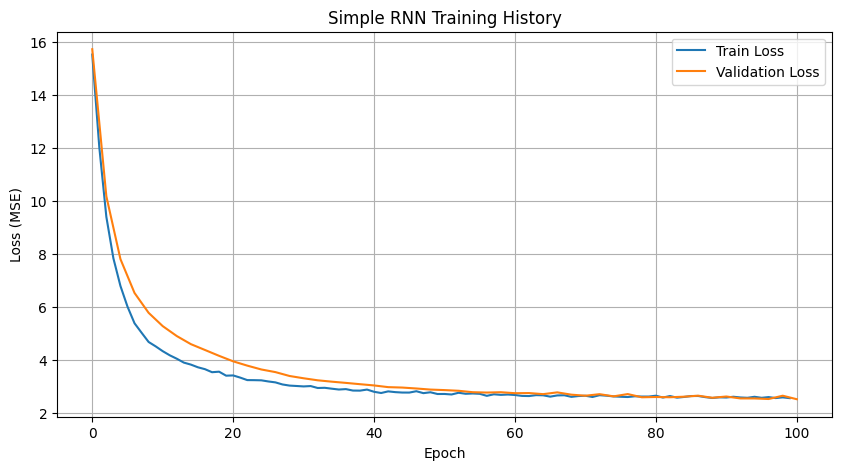

Evaluating Simple RNN on validation set...
Simple RNN Validation Results:
  RMSE: 1.5845
  MAE: 1.0574
  R²: 0.8757


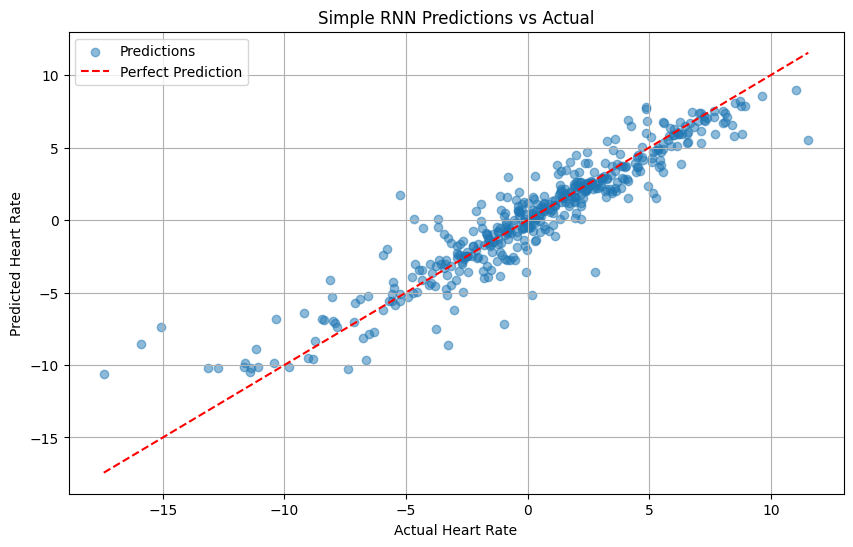

In [ ]:
train_evaluate_plot(
    model=model,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader)

In [ ]:
model = SimpleLSTMModel(
        input_size=input_size,
        hidden_size=32,
        dropout=0.1)
model_name = "Simple LSTM"


===== Training Simple LSTM Model =====


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 17.1094, Val Loss: 18.8833


<ipython-input-28-1f3b0e8b744d>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 15.2714


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 12.3915, Val Loss: 12.9681


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 9.8380


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 8.5111, Val Loss: 9.6599


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 7.3238


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 6.4160, Val Loss: 7.4453


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 5.7488


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 5.2302, Val Loss: 6.2383


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 4.9091


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 4.5541, Val Loss: 5.4553


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 4.2851


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 4.1124, Val Loss: 4.8832


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 3.7475


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 3.6592, Val Loss: 4.4408


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 3.5114


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 3.3325, Val Loss: 4.1226


Epoch 18/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 3.2643


Epoch 19/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 3.1229, Val Loss: 3.8132


Epoch 20/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 3.0520


Epoch 21/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 3.0182, Val Loss: 3.6818


Epoch 22/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 2.9531


Epoch 23/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 2.8700, Val Loss: 3.4806


Epoch 24/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 2.8100


Epoch 25/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 2.7823, Val Loss: 3.3830


Epoch 26/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 2.7240


Epoch 27/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 2.6916, Val Loss: 3.2748


Epoch 28/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 2.6429


Epoch 29/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 2.6060, Val Loss: 3.2274


Epoch 30/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 2.6019


Epoch 31/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 2.5847, Val Loss: 3.2014


Epoch 32/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 2.5096


Epoch 33/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 2.5410, Val Loss: 3.1668


Epoch 34/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 2.5271


Epoch 35/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 2.4791, Val Loss: 3.1163


Epoch 36/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 2.4923


Epoch 37/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 2.4436, Val Loss: 3.0851


Epoch 38/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 2.4010


Epoch 39/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 2.4183, Val Loss: 3.0952


Epoch 40/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 2.4258


Epoch 41/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 2.3245, Val Loss: 3.0930


Epoch 42/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 2.3466


Epoch 43/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 2.4096, Val Loss: 2.9933


Epoch 44/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 2.3360


Epoch 45/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 2.3150, Val Loss: 3.0075


Epoch 46/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 2.3745


Epoch 47/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 2.2869, Val Loss: 2.9866


Epoch 48/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 2.3461


Epoch 49/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 2.2780, Val Loss: 2.9388


Epoch 50/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 2.2374


Epoch 51/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 2.2217, Val Loss: 2.9858


Epoch 52/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 2.2494


Epoch 53/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 2.2585, Val Loss: 2.9454


Epoch 54/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 2.2200


Epoch 55/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 2.1840, Val Loss: 2.9615


Epoch 56/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 2.1539


Epoch 57/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 2.1760, Val Loss: 2.9708


Epoch 58/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 2.1532


Epoch 59/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 2.0846, Val Loss: 2.9228


Epoch 60/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 2.1454


Epoch 61/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 2.1565, Val Loss: 2.9325


Epoch 62/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 2.1054


Epoch 63/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 2.0580, Val Loss: 2.9085


Epoch 64/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 2.0709


Epoch 65/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 2.0805, Val Loss: 2.8919


Epoch 66/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 2.0978


Epoch 67/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 2.0447, Val Loss: 2.8980


Epoch 68/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 1.9971


Epoch 69/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 69/100 - Train Loss: 2.0844, Val Loss: 2.8775


Epoch 70/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 2.0621


Epoch 71/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 71/100 - Train Loss: 2.0173, Val Loss: 2.9340


Epoch 72/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 72/100 - Train Loss: 2.0539


Epoch 73/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 73/100 - Train Loss: 2.0074, Val Loss: 2.8400


Epoch 74/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 74/100 - Train Loss: 1.9423


Epoch 75/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 75/100 - Train Loss: 1.9754, Val Loss: 2.8489


Epoch 76/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 76/100 - Train Loss: 1.9643


Epoch 77/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 77/100 - Train Loss: 1.9599, Val Loss: 2.9213


Epoch 78/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 78/100 - Train Loss: 1.9452


Epoch 79/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 79/100 - Train Loss: 1.9753, Val Loss: 2.7586


Epoch 80/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 1.9481


Epoch 81/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 81/100 - Train Loss: 1.9399, Val Loss: 2.8796


Epoch 82/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 82/100 - Train Loss: 1.8500


Epoch 83/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 83/100 - Train Loss: 1.9069, Val Loss: 2.8070


Epoch 84/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 84/100 - Train Loss: 1.8271


Epoch 85/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 85/100 - Train Loss: 1.8883, Val Loss: 2.8245


Epoch 86/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 86/100 - Train Loss: 1.8515


Epoch 87/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 87/100 - Train Loss: 1.8119, Val Loss: 2.8158


Epoch 88/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 88/100 - Train Loss: 1.8391


Epoch 89/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 89/100 - Train Loss: 1.8994, Val Loss: 2.8744


Epoch 90/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 1.8163


Epoch 91/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 91/100 - Train Loss: 1.7931, Val Loss: 2.8418


Epoch 92/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 92/100 - Train Loss: 1.7328


Epoch 93/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 93/100 - Train Loss: 1.7384, Val Loss: 2.7999


Epoch 94/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 94/100 - Train Loss: 1.7766


Epoch 95/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 95/100 - Train Loss: 1.7086, Val Loss: 2.8279


Epoch 96/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 96/100 - Train Loss: 1.7273


Epoch 97/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 97/100 - Train Loss: 1.6690, Val Loss: 2.8351


Epoch 98/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 98/100 - Train Loss: 1.7143


Epoch 99/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 99/100 - Train Loss: 1.6889, Val Loss: 2.8391
Early stopping at epoch 99


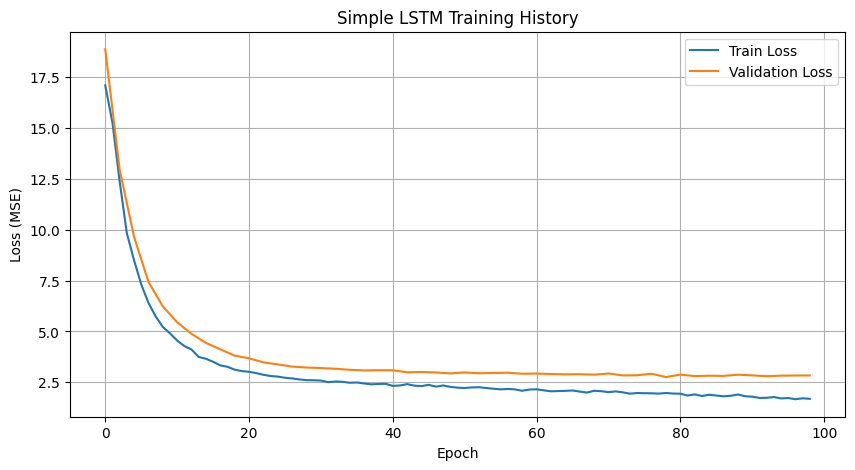

Evaluating Simple LSTM on validation set...
Simple LSTM Validation Results:
  RMSE: 1.6850
  MAE: 1.1455
  R²: 0.8595


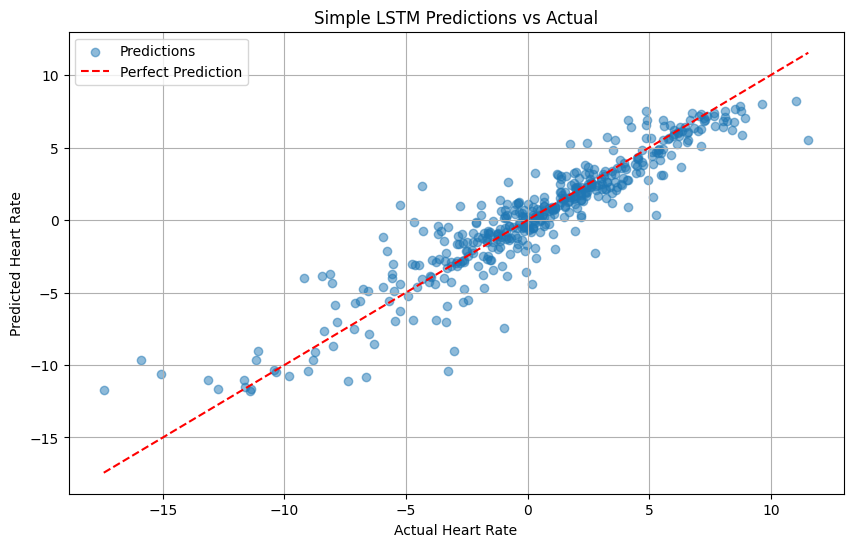

In [ ]:
train_evaluate_plot(
    model=model,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader)

In [ ]:
model = BiLSTMModel(
        input_size=input_size,
        hidden_size=64,
        num_layers=2,
        dropout=0.2)
model_name = "Bi-LSTM"


===== Training Bi-LSTM Model =====


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 15.1818, Val Loss: 13.6390


<ipython-input-28-1f3b0e8b744d>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 8.9173


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 6.6746, Val Loss: 7.0428


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 5.1436


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 4.2983, Val Loss: 4.9765


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 3.7351


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 3.4246, Val Loss: 3.9549


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 3.1208


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 3.0950, Val Loss: 3.5960


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 2.9963


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 2.8841, Val Loss: 3.3484


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 2.7346


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 2.6420, Val Loss: 3.2400


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 2.6509


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 2.6916, Val Loss: 3.2403


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 2.6083


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 2.6159, Val Loss: 3.3157


Epoch 18/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 2.5187


Epoch 19/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 2.4867, Val Loss: 3.0740


Epoch 20/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 2.4845


Epoch 21/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 2.5445, Val Loss: 3.4385


Epoch 22/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 2.5086


Epoch 23/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 2.4602, Val Loss: 3.1008


Epoch 24/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 2.4363


Epoch 25/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 2.3604, Val Loss: 3.0647


Epoch 26/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 2.3023


Epoch 27/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 2.3003, Val Loss: 3.0029


Epoch 28/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 2.3947


Epoch 29/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 2.2934, Val Loss: 3.2269


Epoch 30/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 2.4059


Epoch 31/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 2.2975, Val Loss: 3.0088


Epoch 32/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 2.2883


Epoch 33/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 2.2512, Val Loss: 3.0559


Epoch 34/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 2.2197


Epoch 35/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 2.2889, Val Loss: 3.0239


Epoch 36/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 2.3164


Epoch 37/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 2.1895, Val Loss: 2.9609


Epoch 38/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 2.2222


Epoch 39/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 2.1252, Val Loss: 3.0067


Epoch 40/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 2.0971


Epoch 41/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 2.0676, Val Loss: 2.9602


Epoch 42/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 2.0926


Epoch 43/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 2.1031, Val Loss: 2.8690


Epoch 44/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 2.0615


Epoch 45/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 1.9893, Val Loss: 2.9635


Epoch 46/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 1.9888


Epoch 47/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 2.0120, Val Loss: 2.9332


Epoch 48/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 1.9639


Epoch 49/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 2.0172, Val Loss: 2.9922


Epoch 50/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 1.9736


Epoch 51/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 1.9370, Val Loss: 2.8726


Epoch 52/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 1.8927


Epoch 53/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 1.8961, Val Loss: 2.7860


Epoch 54/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 1.8595


Epoch 55/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 1.8502, Val Loss: 2.8982


Epoch 56/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 1.8153


Epoch 57/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 1.8456, Val Loss: 2.9400


Epoch 58/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 1.7975


Epoch 59/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 1.8588, Val Loss: 3.0143


Epoch 60/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 1.7957


Epoch 61/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 1.7228, Val Loss: 3.0396


Epoch 62/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 1.6767


Epoch 63/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 1.6860, Val Loss: 2.9125


Epoch 64/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 1.6759


Epoch 65/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 1.6369, Val Loss: 2.9112


Epoch 66/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 1.6371


Epoch 67/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 1.6086, Val Loss: 3.0234


Epoch 68/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 1.5744


Epoch 69/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 69/100 - Train Loss: 1.5659, Val Loss: 2.9471


Epoch 70/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 1.5677


Epoch 71/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 71/100 - Train Loss: 1.5255, Val Loss: 3.0105


Epoch 72/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 72/100 - Train Loss: 1.5282


Epoch 73/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 73/100 - Train Loss: 1.5344, Val Loss: 3.0331
Early stopping at epoch 73


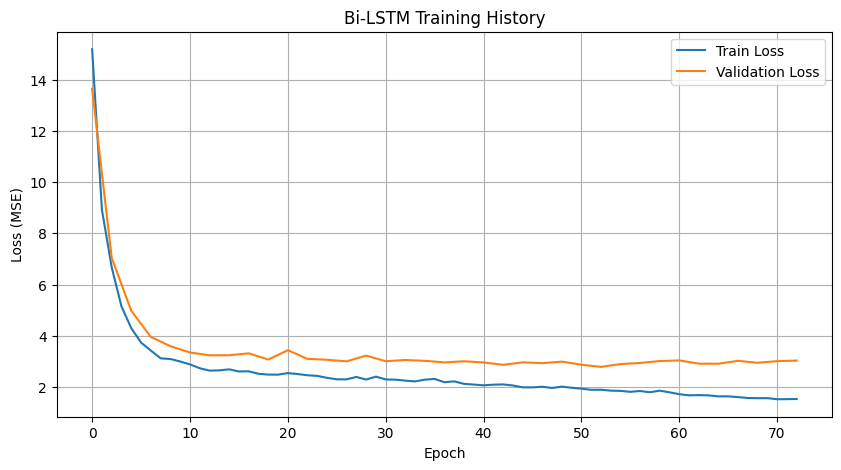

Evaluating Bi-LSTM on validation set...
Bi-LSTM Validation Results:
  RMSE: 1.7416
  MAE: 1.1967
  R²: 0.8499


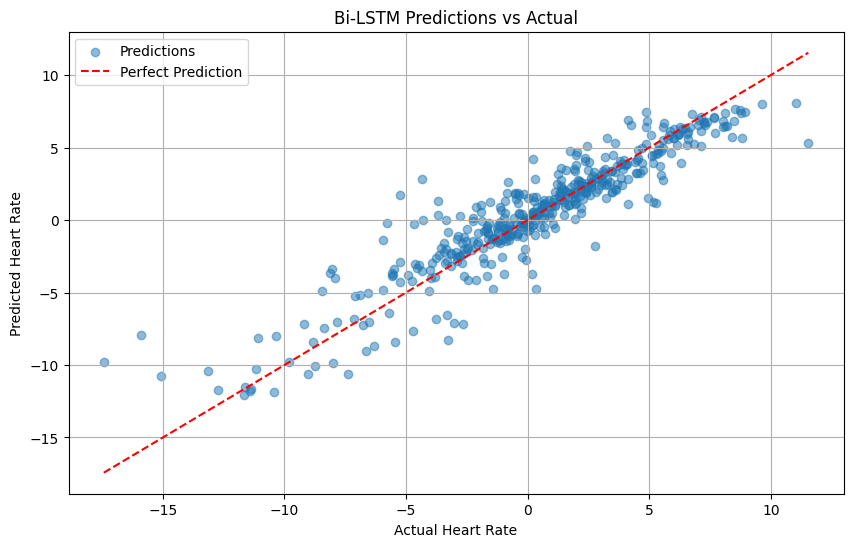

In [ ]:
train_evaluate_plot(
    model=model,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader)

In [ ]:
model = AttentionLSTM(
        input_size=input_size,
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    )
model_name = "LSTM with Attention"


===== Training LSTM with Attention Model =====


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 16.5633, Val Loss: 17.3298


<ipython-input-28-1f3b0e8b744d>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 12.7980


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 9.5768, Val Loss: 10.4463


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 7.7426


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 6.5044, Val Loss: 7.6447


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 5.7142


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 5.2413, Val Loss: 6.5161


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 4.7109


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 4.4503, Val Loss: 5.0639


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 4.0372


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 3.8054, Val Loss: 4.0127


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 3.4548


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 3.1943, Val Loss: 3.6589


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 3.2020


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 3.0174, Val Loss: 3.3259


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 2.9609


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 2.9754, Val Loss: 3.2293


Epoch 18/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 2.9838


Epoch 19/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 3.0947, Val Loss: 3.2579


Epoch 20/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 2.9541


Epoch 21/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 2.8166, Val Loss: 3.0601


Epoch 22/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 2.7256


Epoch 23/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 2.6764, Val Loss: 2.8720


Epoch 24/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 2.5891


Epoch 25/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 2.5909, Val Loss: 2.8625


Epoch 26/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 2.5482


Epoch 27/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 2.6099, Val Loss: 2.8872


Epoch 28/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 2.5957


Epoch 29/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 2.5346, Val Loss: 2.7419


Epoch 30/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 2.4951


Epoch 31/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 2.5238, Val Loss: 2.7395


Epoch 32/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 2.4650


Epoch 33/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 2.4470, Val Loss: 2.7159


Epoch 34/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 2.4797


Epoch 35/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 2.3701, Val Loss: 2.7242


Epoch 36/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 2.4747


Epoch 37/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 2.4054, Val Loss: 2.6893


Epoch 38/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 2.4345


Epoch 39/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 2.4104, Val Loss: 2.6515


Epoch 40/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 2.4346


Epoch 41/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 2.2829, Val Loss: 2.6475


Epoch 42/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 2.2619


Epoch 43/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 2.3293, Val Loss: 2.7284


Epoch 44/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 2.3621


Epoch 45/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 2.2673, Val Loss: 2.6802


Epoch 46/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 2.2566


Epoch 47/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 2.1888, Val Loss: 2.6657


Epoch 48/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 2.2446


Epoch 49/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 2.2421, Val Loss: 2.6567


Epoch 50/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 2.2180


Epoch 51/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 2.1364, Val Loss: 2.5865


Epoch 52/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 2.1953


Epoch 53/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 2.1727, Val Loss: 2.6560


Epoch 54/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 2.1489


Epoch 55/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 2.1371, Val Loss: 2.7191


Epoch 56/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 2.2001


Epoch 57/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 2.1027, Val Loss: 2.7298


Epoch 58/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 2.1141


Epoch 59/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 2.1024, Val Loss: 2.6655


Epoch 60/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 2.1674


Epoch 61/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 2.1241, Val Loss: 2.5503


Epoch 62/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 2.0546


Epoch 63/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 1.9916, Val Loss: 2.5842


Epoch 64/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 2.0559


Epoch 65/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 1.9566, Val Loss: 2.6370


Epoch 66/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 2.0369


Epoch 67/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 1.9189, Val Loss: 2.5944


Epoch 68/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 2.0371


Epoch 69/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 69/100 - Train Loss: 2.0179, Val Loss: 2.7665


Epoch 70/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 1.9095


Epoch 71/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 71/100 - Train Loss: 1.9962, Val Loss: 2.6269


Epoch 72/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 72/100 - Train Loss: 1.8798


Epoch 73/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 73/100 - Train Loss: 1.9359, Val Loss: 2.6687


Epoch 74/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 74/100 - Train Loss: 1.9337


Epoch 75/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 75/100 - Train Loss: 1.8199, Val Loss: 2.5762


Epoch 76/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 76/100 - Train Loss: 1.8904


Epoch 77/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 77/100 - Train Loss: 1.8960, Val Loss: 2.6146


Epoch 78/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 78/100 - Train Loss: 1.7693


Epoch 79/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 79/100 - Train Loss: 1.8323, Val Loss: 2.5010


Epoch 80/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 1.7662


Epoch 81/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 81/100 - Train Loss: 1.7946, Val Loss: 2.5927


Epoch 82/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 82/100 - Train Loss: 1.7266


Epoch 83/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 83/100 - Train Loss: 1.7017, Val Loss: 2.5827


Epoch 84/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 84/100 - Train Loss: 1.6947


Epoch 85/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 85/100 - Train Loss: 1.7055, Val Loss: 2.6039


Epoch 86/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 86/100 - Train Loss: 1.7325


Epoch 87/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 87/100 - Train Loss: 1.6855, Val Loss: 2.6348


Epoch 88/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 88/100 - Train Loss: 1.6873


Epoch 89/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 89/100 - Train Loss: 1.6590, Val Loss: 2.6680


Epoch 90/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 1.6701


Epoch 91/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 91/100 - Train Loss: 1.6981, Val Loss: 2.7436


Epoch 92/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 92/100 - Train Loss: 1.6416


Epoch 93/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 93/100 - Train Loss: 1.6377, Val Loss: 2.6255


Epoch 94/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 94/100 - Train Loss: 1.6336


Epoch 95/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 95/100 - Train Loss: 1.5923, Val Loss: 2.7143


Epoch 96/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 96/100 - Train Loss: 1.5366


Epoch 97/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 97/100 - Train Loss: 1.5098, Val Loss: 2.8573


Epoch 98/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 98/100 - Train Loss: 1.6253


Epoch 99/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 99/100 - Train Loss: 1.5178, Val Loss: 2.6091
Early stopping at epoch 99


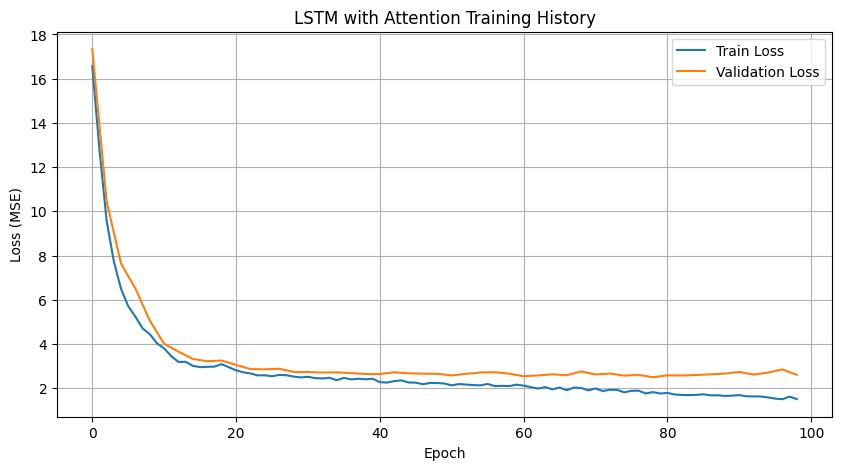

Evaluating LSTM with Attention on validation set...
LSTM with Attention Validation Results:
  RMSE: 1.6153
  MAE: 1.1311
  R²: 0.8709


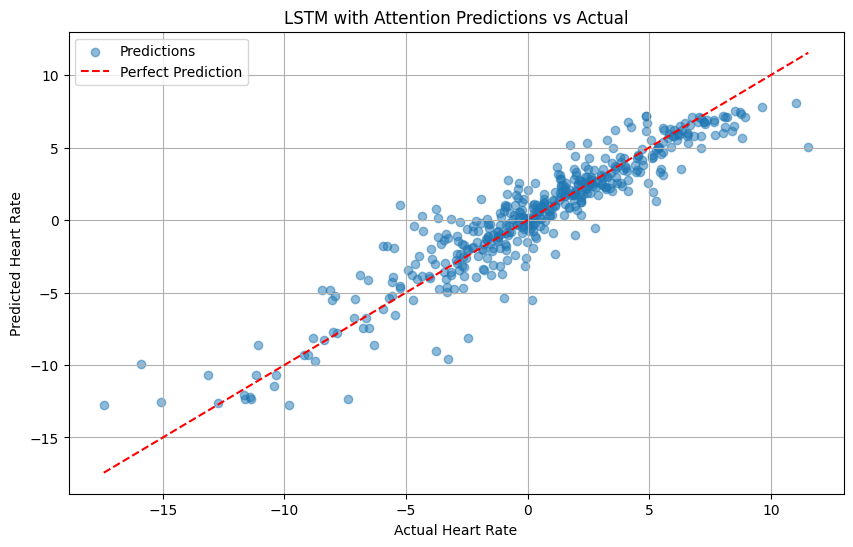

In [ ]:
train_evaluate_plot(
    model=model,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader)

In [ ]:
model = CNNLSTMModel(
        input_size=input_size,
        seq_length=10,
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    )
model_name = "CNN-LSTM Hybrid"


===== Training CNN-LSTM Hybrid Model =====


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?it/s]

<ipython-input-28-1f3b0e8b744d>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/100 - Train Loss: 16.9583, Val Loss: 17.5932


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 12.6548


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 9.3183, Val Loss: 10.0449


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 7.7253


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 6.3623, Val Loss: 6.7867


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 5.2879


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 4.6141, Val Loss: 5.5477


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 4.4246


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 4.0014, Val Loss: 4.7483


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 3.9855


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 3.8311, Val Loss: 4.3274


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 3.7339


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 3.6197, Val Loss: 4.2632


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 3.5141


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 3.4036, Val Loss: 3.8113


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 3.2798


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 3.1501, Val Loss: 3.7251


Epoch 18/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 3.1773


Epoch 19/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 3.1183, Val Loss: 3.7972


Epoch 20/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 3.1261


Epoch 21/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 2.9692, Val Loss: 3.5688


Epoch 22/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 2.9464


Epoch 23/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 2.8159, Val Loss: 3.5793


Epoch 24/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 2.6832


Epoch 25/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 2.7801, Val Loss: 3.6672


Epoch 26/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 2.7408


Epoch 27/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 2.6280, Val Loss: 3.5410


Epoch 28/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 2.5666


Epoch 29/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 2.6289, Val Loss: 3.6385


Epoch 30/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 2.4697


Epoch 31/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 2.4683, Val Loss: 3.9553


Epoch 32/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 2.4887


Epoch 33/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 2.3020, Val Loss: 3.6971


Epoch 34/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 2.2758


Epoch 35/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 2.2443, Val Loss: 3.5560


Epoch 36/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 2.1223


Epoch 37/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 2.1725, Val Loss: 3.5345


Epoch 38/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 2.1407


Epoch 39/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 2.0951, Val Loss: 3.6154


Epoch 40/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 2.0401


Epoch 41/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 1.9958, Val Loss: 3.6972


Epoch 42/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 1.9411


Epoch 43/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 1.9595, Val Loss: 3.5676


Epoch 44/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 1.9145


Epoch 45/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 1.9355, Val Loss: 3.6462


Epoch 46/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 1.8726


Epoch 47/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 1.9340, Val Loss: 3.5776


Epoch 48/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 1.8669


Epoch 49/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 1.7967, Val Loss: 3.7675


Epoch 50/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 1.8179


Epoch 51/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 1.7100, Val Loss: 3.7302


Epoch 52/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 1.8716


Epoch 53/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 1.7651, Val Loss: 3.7415


Epoch 54/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 1.6236


Epoch 55/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 1.5623, Val Loss: 3.8599


Epoch 56/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 1.5643


Epoch 57/100:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 1.5686, Val Loss: 3.7378
Early stopping at epoch 57


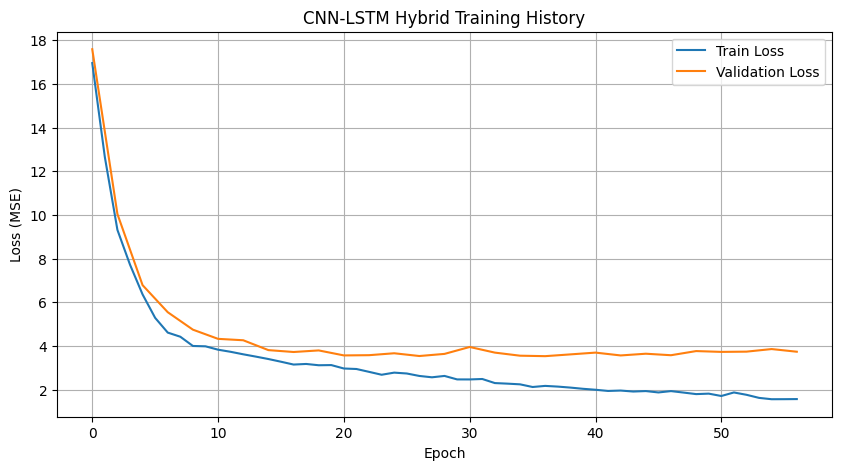

Evaluating CNN-LSTM Hybrid on validation set...
CNN-LSTM Hybrid Validation Results:
  RMSE: 1.9333
  MAE: 1.3541
  R²: 0.8150


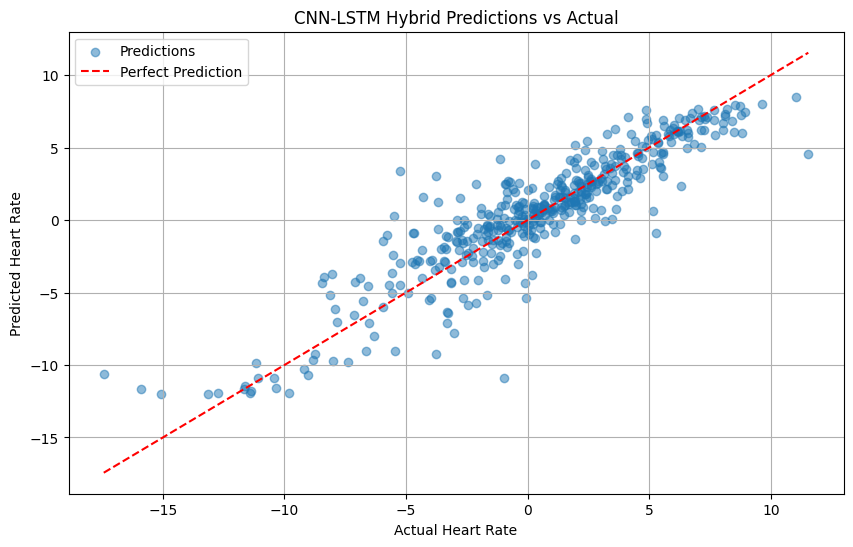

In [ ]:
train_evaluate_plot(
    model=model,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader)